**020-probabillity**

# Basic Probability Theory and Bayes Rule

This week we are mostly working with mathematics, and much less with programming.  In order to not completely loose the connection between the math and the computational analyses, we implement some minor elements.

In this notebook we present the basic libraries we will be using in the course. These are:
1. [Limit behavior of a coin](#Simulating-a-frequentist-limit-(The-Law-of-Big-Numbers))
2. [Density](#Approximating-probability-density)
3. [Bayesian analysis of a coin bias](#Bayesian-Inference-for-Bernoulli-Distribution)![main.ipynb](attachment:main.ipynb)

In [1]:
import math
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc3 as pm

## Simulating a frequentist limit (The Law of Big Numbers)

https://whatis.techtarget.com/definition/law-of-large-numbers

Frequentist probability or frequentism is an interpretation of probability; it defines an event's probability as the limit of its relative frequency in many trials.
* We begin with reproducing Fig. 4.1 in the book, a frequentist interpretation of probability.  
* Two constants govern this plot:  'size' and 'bias'. 
* Tinker with them to obtain graphs estimating the bias for various coins.  
* Of course, it is slightly circular what we are doing here: we generate data from a Bernouli distribution to estimate the bias in the limit of the same Bernouli distribution.  

* In a real Bernouli experiment (or for a "real coin"), we obtain the data completely differently, not from a sampler.  The plotting and limit computation stuff is the same though.

In [ ]:
# Tinker with these prefixes (try some clear bias, and a small size, increase the size to see the impact on convergence)
size = 500
bias = 0.5

with pm.Model() as model1:
  heads = pm.distributions.discrete.Bernoulli(p=bias, name="coin")
  sample = pm.sample(draws=size)

def heads_in_prefix(i): 
    return np.sum(sample['coin'][1:i+1])/i
    # A hack: skipping the 0th when computing the proportion 
    # we will plot from sample['coin'][1] anyways because of the logarithmic scale

# compute the accumulative frequencies (for plotting)
proportion_t = [heads_in_prefix(i) for i in range(size)]

# compute the prefix as a string (for the figure label like in the book)
prefix = "".join ([('H' if h==1 else 'T') for h in sample['coin'][1:11]])

(Remark: The book uses this example before introducing probability, so using the Bernoulli distribution with its parameters and sampling is a bit premature.  A direct simulator of a random outcome and then plotting the proportion of heads would be more in the spirit of opening of Chapter 4.  However, this is really what sampling from Bernoulli distribution is, and the advantage is what we are learning the standard APIs that we will use many times later in the course).

In [ ]:
# Make the Plot
plt.axis([1, size+1, 0, 1])      #xmin, xmax, ymin, ymax                                         # Cropping
plt.xscale('log')                                                        # Set log scale
plt.plot(proportion_t, 'o-', linewidth=.5, color='C0', fillstyle='none') # The series of proportions as a (converging) line                                                                                                                                                                                    
plt.axhline(y=bias, linestyle=':', color='C1')                           # The real Bernouli bias parameter as a (constant) line
plt.title("Proportion of heads")                                                                                                                                                                                                               
plt.xlabel("Flip number")                                                                                                                                                                                                                      
plt.ylabel("Proportion Heads")
plt.text(20,0.75,f"Flip Sequence {prefix}...")
plt.text(20,0.65,f"End Proportion {proportion_t[size-1]:.3f}")
plt.show()

## Approximating probability density
We are now going to reproduce Fig. 4.2 from the book.  
* The idea is to draw a discretization of probability mass from a continous distribution (people's height)
* And "simulate" the integral behavior by decreasing the size of the buckets.
* Let's start with loading the data of people's height from last week.

In [ ]:
size = 10000
data = pd.read_csv('../010-intro/nhis-modified.csv').head(size) 
height = data['height']

* Now we prepare the scatter plot showing where folk's height is concentrated. Compare with the top plot in Fig. 4.2 in the book.  
* There are slight differences in the distribution, as we are using a different dataset.

In [ ]:
fig=plt.figure()
# axes is the plural form of the word axis
# add_axes: The dimensions [left, bottom, width, height] of the new axes. Allquantities are in fractions of figure width and height.
ax=fig.add_axes([0,0,2,1])
ax.scatter(height, range(size), marker='.')
ax.axis([58, 78, 0, size])
ax.set_title(f"Total N = {size}")
plt.ylabel("Person #")
plt.show()

Why we do not calculate the probability density with help of integral!
 We could do that. Here for pedagogical purpose we calculate the robability density through equation 4.2 (p.84) in the book:
 
suming up Deltas

$\Delta $  = Area of each bin (bucket) which can be calculated as width of bin times hight of bin

* For the second part of the figure we plot a histogram of given bin density. 
* You should experiment with various bin sizes.
* The diagrams with smaller bin widths will approximate the density better and better.  
* When we calculate the probability density analytically we take a limit of these densities with bin_width approaching zero.  
* This is giving the integral of the function.  However, when we work with samples, as soon as the bin width becomes small with respect to the sample size, we are starting to get more and more empty buckets and spikes caused by randomness in the sample.  
* Try to replicate this effect by manipulating 'bin_width' and rerunning the plot below.  

should the probability density at empty buckets be 0?  Yes
bin_width = 4  ,  x = 78.26562145432657441654  => p(78.26562145432658) = 0.0

In [ ]:
bin_width = 0.1 # try bin sizes 4, 2, 1, 0.5

fig=plt.figure()
ax=fig.add_axes([0,0,2,1])
bins = np.arange(50, 85, bin_width)
# TODO if false does it return mass? Yes
hist = ax.hist(height, bins, rwidth=0.9, density=True)
# hist returns a pair of vectors: a vector of counts (prob. mass) and a vector of bins (repeated)
# these are not needed for plotting, but we use them below to compute a density in the interval
ax.set_title("Height (inches)") 
plt.ylabel("Probability Density")
###
# rect : sequence of float
#             The dimensions [left, bottom, width, height] of the new axes. All
#             quantities are in fractions of figure width and height.
# ax=fig.add_axes([0,1.2,1,1]) 
# bins2 = np.arange(50, 85, 2)
# hist2 = ax.hist(height, bins2, rwidth=0.9, density=True)

# ax=fig.add_axes([1,1.2,1,1])
# bins4 = np.arange(50, 85, 4)
# hist4 = ax.hist(height, bins4, rwidth=0.9, density=True)

# ax=fig.add_axes([1,0,1,1])
# bins05 = np.arange(50, 85, 0.5)
# hist05 = ax.hist(height, bins05, rwidth=0.9, density=True)
###
plt.show()

# Let's find the bin containing 63 inches (like the book) and compute the density in this bin
x = 63
ix = next(i for i,v in enumerate(bins) if v > x)-1
print (f"estimated density at {x}, p({x}) = {hist[0][ix]}")

Some review questions:
1. If you want to get more efficient with matplotlib plotting, modify the code, to show a range of graphs next to each other, in a single figure, for different bin_width.
2. Another reflection question: flip the density parameter in `ax.hist` to False, and reflect on the impact on the graph.  Watch the Y-axis, and reflect on the difference between mass and density. 
3. How shall we change the code to draw a probability mass histogram instead?

## **Bayesian Inference for Bernoulli Distribution (using Grid Approximation)**
* We will now use equation 5.10, 5.11, 5.7, and 5.8 to estimate posterior probability for selected possibly values of theta (reproducing Fig. 5.1 and Fig. 5.2.)
* This is called grid approximation (the book is introducing this name in passing (briefly and casually) in this chapter, easy to miss, but it becomes increasingly important later)
* Grid approximation is an easy technique that requires just basic programming (loops and arithmetic)
* We pick a selected number of points from the domain of parameters (we discretize it)
* And compute the posterior probability from the definition for these points.
* Note: none of the code below uses PyMC3 or any other inference algorithms

Equation 5.7
p(θ|D) = $ \frac{p(D|θ) p(θ)}{p(D)} $    posterior = $\frac{likelihood * prior}{evidence}$

Equation 5.8
p(D) = $ \sum\limits_{\theta ^ *}^{} p(D| \theta ^ *) p(\theta ^ *)$  normalization. evidence

Equation 5.10
p(y|θ) = $θ ^ y (1 − θ) ^ {1−y}$

In [ ]:
domain = np.arange (0.0,1.01,0.1)      # this is the actual plottable domain (with 0.0 and 1.0). 
prior  = [0.0, 0.04, 0.08, 0.12, 0.16, 0.20, 0.16, 0.12, 0.08, 0.04, 0.0] # prior probabilities for θ
assert (sum(prior)==1.0)

# Equation 5.10
def likelihood (y, theta): 
    if y: return theta
    else: return (1-theta)

# Equation 5.8    
def normalization_const (y): 
    return np.sum(np.multiply(likelihood (y, domain), prior)) # numpy operations are faster than python (this will matter more for larger data sets)

denominator = normalization_const (True)

# Equation 5.7
posterior_theta = np.multiply(likelihood (True, domain), prior) / denominator 

* Above we defined the prior, likelihood, and the posterior, we now plot them for all the values of theta (in the domain list)
* All the important calculation happened above.
* The likelihood and posterior is computed for the data set that contains one observation (a single toss, showing head)

In [ ]:
fig, ax = plt.subplots(1,3, figsize=(20,5))

ax[0].set_title('The prior (graphed directly from definition)')
ax[0].set_xlabel('θ')
ax[0].set_ylabel('p(θ)')
ax[0].bar(domain, prior, width=0.02, alpha=0.5)
ax[0].set_xticks(domain) 
ax[0].axis([-0.05, 1.05, -0.001, 0.251]) #xmin, xmax, ymin, ymax

ax[1].text(0.0,0.95,"Data: z=1, N=1")
ax[1].set_title('The likelihood graphed from equation 5.11')
ax[1].set_xlabel('θ')
ax[1].set_ylabel('p(D|θ)')
ax[1].bar(domain, likelihood(True,domain), width=0.02, alpha=.5)
ax[1].set_xticks(domain)
ax[1].set_yticks(domain)
ax[1].axis([-0.05, 1.05, -0.001, 1.05])

ax[2].set_xlabel('θ')
ax[2].bar(domain, posterior_theta, width=0.02, alpha=0.5)
ax[2].set_title('Posterior observing (z=1, N=1) graphed from Bayes rule')
ax[2].set_xlabel('θ')
ax[2].set_ylabel('p(θ|D)')
ax[2].set_xticks(domain)
ax[2].set_yticks(domain)
ax[2].axis([-0.02, 1.02, -0.001, 0.25])

plt.show()

Equation 5.11

p({$ y_i$ }|θ) = $\theta ^ {\#\textrm{heads}}  (1 − θ) ^ {\#\textrm{tails}} $


* Observe above that the likelihood integral (sum) is not 1. 
* Likelihood is the conditional probability, where we fixed the random variable and free the parameter --- so we change the domain, and thus the value range of the function.
* Also observe that the maximum likelihood value of θ is inconsistent with the prior.  What the posterior gives us, is some kind of reconciliation of the likelihood with the prior (to the right above)
* Even though we have only one experiment: we have only seen a head, unlike in the frequentist interpretation, we have not estimated θ to be 1 yet. The posterior distribution is only slightly shifted to the right.

We shall now attempt to recreate Fig. 5.2 so plot prior's likelihoods and posteriors for longer experiments (more coin tosses and more heads observed)
* We first create 1000 possible values for θ (so we increase granularity)
* Then we generalize our model (wrap it in a function), so that we can try on data of various sizes and compare the plots
* Finally, we collect the grid of 1001 posterior values for two experiments with N=4 and N=40

In [3]:
domain = np.arange (0.0,1.0001,0.001)      
prior  = np.append(np.linspace(0,0.002,501), np.linspace(0.001996,0,500))

# Equation 5.11
def likelihood(z, N, θ):
    return (θ**z) * ((1-θ)**(N-z)) 

# Equation 5.8 (we use numpy operations on arrays for speed)   
def normalization_const_n (z, N): 
    return np.sum(np.multiply (likelihood (z,N,domain), prior))

# Equation 5.7
def posterior_n (z,N):
    denominator = normalization_const_n (z, N)
    numerator = np.multiply(likelihood (z, N, domain), prior)
    return numerator / denominator 

posterior_N4 = posterior_n(1, 4)
posterior_N40 = posterior_n(10, 40)

* Now for plotting (Fig. 5.2)

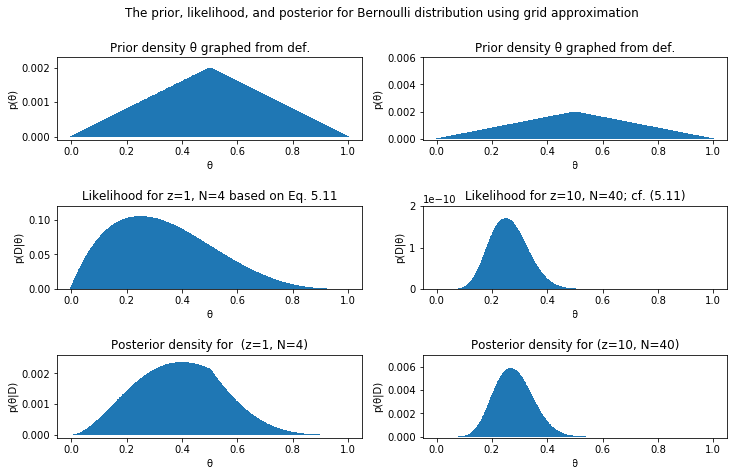

In [4]:
fig, ax = plt.subplots(3,2, figsize=(12,7))
fig.suptitle('The prior, likelihood, and posterior for Bernoulli distribution using grid approximation')
fig.subplots_adjust(hspace = 0.8) # add some vertical whitespace so that plots do not overlap

# both priors are the same (the only seem different in the book for an ad hoc reason?)
ax[0,0].set_title('Prior density θ graphed from def.')
ax[0,0].set_xlabel('θ')
ax[0,0].set_ylabel('p(θ)')
# (The x coordinates of the bars, The height(s) of the bars,  The width(s) of the bars (default: 0.8)) 
ax[0,0].bar(domain, prior, width=0.01)
ax[0,0].axis([-0.05, 1.05, -0.0001, 0.0023])

ax[0,1].set_title('Prior density θ graphed from def.')
ax[0,1].set_xlabel('θ')
ax[0,1].set_ylabel('p(θ)')
ax[0,1].bar(domain, prior, width=0.01)
ax[0,1].axis([-0.05, 1.05, -0.0001, 0.006])

# # likelihoods
ax[1,0].set_title('Likelihood for z=1, N=4 based on Eq. 5.11')
ax[1,0].set_xlabel('θ')
ax[1,0].set_ylabel('p(D|θ)')
ax[1,0].bar(domain, likelihood(1, 4, domain), width=0.01)
ax[1,0].axis([-0.05, 1.05, -0.0001, 0.12])

ax[1,1].set_title('Likelihood for z=10, N=40; cf. (5.11)')
ax[1,1].set_xlabel('θ')
ax[1,1].set_ylabel('p(D|θ)')
ax[1,1].bar(domain, likelihood(10, 40, domain), width=0.01)
ax[1,1].axis([-0.05, 1.05, 0.0, 2.0e-10])

# posterior
ax[2,0].set_title('Posterior density for  (z=1, N=4)')
ax[2,0].set_xlabel('θ')
ax[2,0].set_ylabel('p(θ|D)')
ax[2,0].bar(domain, posterior_N4, width=0.01)
ax[2,0].axis([-0.05, 1.05, -0.0001, 0.0026])

ax[2,1].set_title('Posterior density for (z=10, N=40)')
ax[2,1].set_xlabel('θ')
ax[2,1].set_ylabel('p(θ|D)')
ax[2,1].bar(domain, posterior_N40, width=0.01)
ax[2,1].axis([-0.05, 1.05, -0.0001, 0.007])

plt.show()

A variable in mathematics is a symbol that has multiple values, in other words the value of it varies depending on conditions.

A parameter is very similar to a variable in that the value also varies (but is normally defined as being within a certain area), however a parameter is a 'link' between two other variables.

Unlike probability density functions, likelihoods aren’t normalized. The area under their curves does not have to add up to 1.

Although a likelihood function might look just like a probability density function, it’s fundamentally different. A probability density function is a function of x, your data point, and it will tell you how likely it is that certain data points appear. A likelihood function, on the other hand, takes the data set as a given, and represents the likeliness of different parameters for your distribution.

The mean is the average of a data set. The mode is the most common number in a data set. The median is the middle of the set of numbers.

**mode:** The mode is the number that appears most often in a set of numbers. The mode is the most frequently occurring value. Like the statistical mean and median, the mode is a way of capturing important information about a random variable.

In [ ]:
print(prior[0:10])

**Figure 5.2 The two columns show different sample sizes with the same proportion of heads. The prior
is the same in both columns but plotted on a different vertical scale. The influence of the prior is
overwhelmed by larger samples, in that the peak of the posterior is closer to the peak of the likelihood
function. Notice also that the posterior HDI is narrower for the larger sample.**

# TODO Why we are estimating mode not mean!

Sometimes the mode can be more usefull. It depends on the shape of distribiotion

* Since we are plotting approximation grids directly, there is no support for HPD/HDI. We could calculate it brute force and draw it. It is a good exercise to take an array like posterior_N40 and compute 95% HDI (assuming that the distrbution is unimodal, which is the case here, it suffices to sort the array, sum the prefix until you see more than 0.95 and find the bounderies from the associated indices).  Plotting is done with plt.hlines.
* Similarly finding the mode is very easy for a discrete distribution with pmf stored in an array.  You can plot it with plt.vlines.

# Some questions to ponder for you during review:
1. (a trick question) The two top graphs for the prior look roughly the same above, and quite different in the book in Fig. 5.2. Why?
2. Why is the likelihood lower for N=40 than for N=4?
3. Why is the mode of the posterior for N=40 to the left, with respect to the mode of the posterior for N=4?
4. Looking at the posteriors: can you reject the hypothesis that the coin is unbiased in the left experiment (N=4)? Can you in the right experiment (N=40)? Explain why. Hint: use HDI calculations from above.
5. What does the N parameter control in the above code? And why our bar plots are smooth now, and they were bars in the previous image? What parameter controls this behavior?

1) Due to diffrent y axis!

2) (Since the candidates value for θ are different. 10 vs 1000) -> wring
In the case of n=40, we have observed 40 trials but in the case of n=4, we only have observed 4 trials.

4) Not for the left one but for the right one. Simply by looking at the shape of posterior distribution! the right one has HDI narrower which means getting this probability is more certain.

5) N is the number of trials and S is the number of samples for each trials.


**Exercise 4.3**

(A) There are 8 cards of value 10. Hence the probability of getting a 10 is 8/48 = 0.1666...

(B) The values 10 and Jack are mutually exclusive, so we add their probabilities to get the
probability of the event that contains either 10 or Jack. Each has probability 8/48, so the
probability of 10 or Jack is 8/48 + 8/48 = 0.333...

In [ ]:
# p(x) = 6x(1 − x)
#  Exercise 4.4
import numpy as np 
import matplotlib.pyplot as plt
from scipy.integrate import quad

# A)
xlow = 0 # Specify low end of x-axis.
xhigh = 1 # Specify high end of x-axis.
dx = 0.02 # Specify interval width on x-axis
#Specify comb of points along the x axis:
x = np.arange(xlow, xhigh, dx)
# Compute y values, i.e., probability density at each value of x:
y = 6 * x * (1 - x)

fig=plt.figure()
# add_axes: The dimensions [left, bottom, width, height] of the new axes. Allquantities are in fractions of figure width and height.
ax=fig.add_axes([0,0,1,1.5])
# widths = np.ones_like(x)
# TODO how to make the edges visible?  The plot is correct. Maybe width = 0.002
ax.bar(x, y, width=0.02)
ax.set_title('Probability Density: 6x(1-x)')
ax.set_xlabel("x")
ax.set_ylabel("P(x)")

# Approximate the integral as the sum of width * height for each interval. 
area = sum( dx * y ) # Numerical (Approximate) 
ax.text(0.5, 1.5, "Area under the curve is {}".format(area))

# B)
def p(x):
    return 6 * x * (1 - x)

integral, err = quad(p,0,1) # Analytical
print(f"Integral is {integral}")
# import sympy as sp # Analytical
# result = integrate.quad(y , 0, 1)  # Numerical (Approximate)

# C)
# Yes, the integral is 1.0, so the function satisfies Eqn 4.3.

# D)
# From the graph, it appears that the maximum density is 1.5 when x-0.5. Indeed, 6*0.5*(1-0.5) = 1.5.
plt.show()

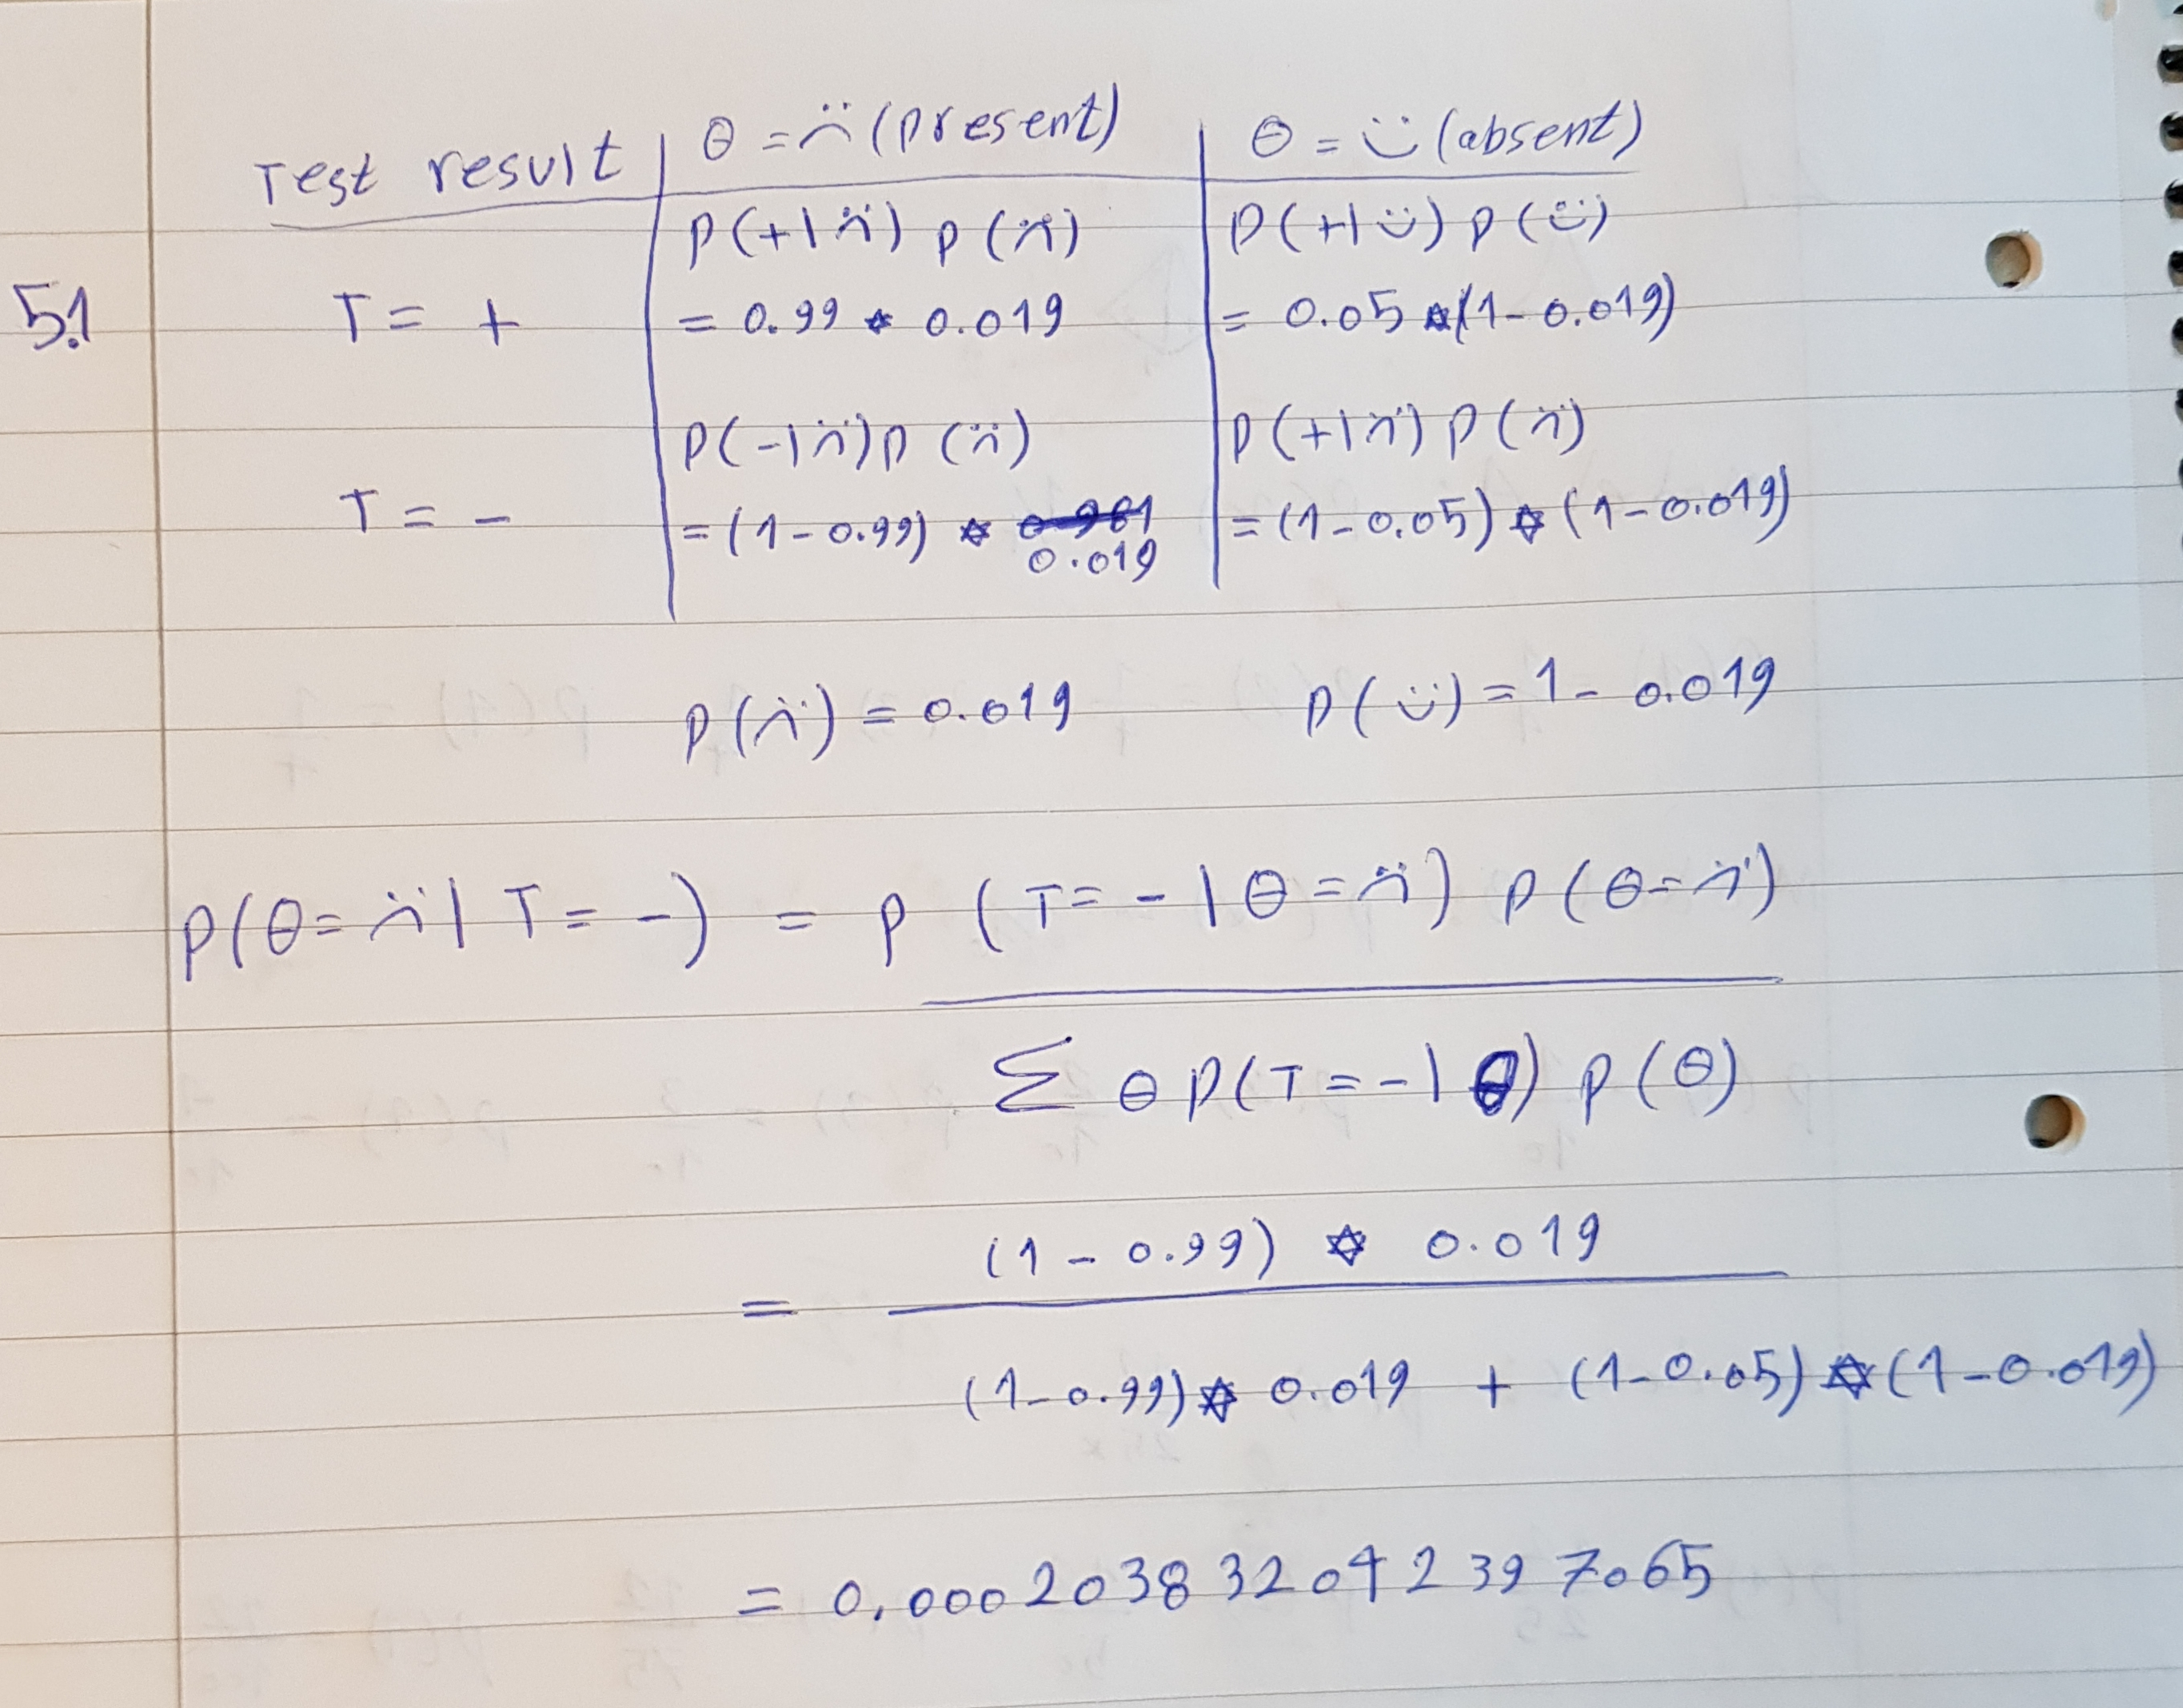

In [ ]:
numi = (1 - 0.99) * 0.019
demi = numi + (1 - 0.05) * (1 - 0.019)
res = numi / demi
print(res)